In [1]:
from nltk.tokenize import word_tokenize
import numpy as np
from tensorflow import keras

Below is the import and define of GloVe, takes a while but once it's done we dont need to repeat it. <br>
!!!!!!!!!!!!!!!!!!!!!!!!<br>Make sure your file address for this code contains "glove.6B.50d.txt"<br>
If not, get it with Google Drive or https://nlp.stanford.edu/projects/glove/ 


In [2]:
def glove():
    # Glove vector contains a 50 dimensional vector corresponding 
    # to each word in dictionary.
    vocab_f = 'glove.6B.50d.txt'
 
    # embeddings_index is a dictionary which contains the mapping of
    # word with its corresponding 50d vector.
    embeddings_index = {}
    with open(vocab_f, encoding='utf8') as f:
        for line in f:
            # splitting each line of the glove.6B.50d in a list of 
            # items- in which the first element is the word to be embedded,
            # and from second to the end of line contains the 50d vector.
            values = line.rstrip().rsplit(' ')
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs
    return embeddings_index

embeddings_index = glove()

Define the processing of input and function for prediction, pretty much the same as the FirstCode_DBM140

In [3]:
class Usertest:
    def __init__(self):
        self.user_input = []

    def lower_texts(self,user_input):
        # Each  sentence in feel_arr is tokenized by the help of work tokenizer.
        # If I have a sentence - 'I am happy'. 
        # After word tokenizing it will convert into- ['I','am','happy']
        lower_texts = [word_tokenize(sent.lower()) for sent in user_input]
        return lower_texts
    
    def padding (self,lower_texts):
        # Defined a function padd in which each sentence length is fixed to 200.
        # If length is less than 200 , then the word- '<padd>' is append
        def padd(arr):
            for i in range(200-len(arr)):
                arr.append('<pad>')
            return arr[:200]
        # call the padd function for each sentence in feel_arr
        for i in range(len(lower_texts)):
            lower_texts[i]=padd(lower_texts[i])
        return lower_texts


    def embedding (self,lower_texts,embeddings_index):
        # Embedding each word of the feel_arr
        embedding_texts = []
        # Iterate through each sub-list (sentences)
        for word_list in lower_texts:
            # Initialize an empty list to store the embedding vectors for each word
            word_vectors = []
            for word in word_list:
                if word in embeddings_index:
                    word_vector = embeddings_index[word]
                    word_vectors.append(word_vector)
                else:
                    # if the word to be embedded is '<padd>' append 0 fifty times
                    word_vector = np.zeros(50, dtype='float32')
                    word_vectors.append(word_vector)
            embedding_texts.append(word_vectors)
            X = np.array(embedding_texts)
        return  X

    def importmodel (self,path):
        model = keras.models.load_model(path)
        return model
    
    def predict (self,model,X):
        prediction = model.predict(X,verbose=0)
        return prediction
    



    def run(self,user_input,embeddings_index,path):
        lower_texts = self.lower_texts(user_input)
        lower_texts = self.padding(lower_texts)
        X = self.embedding (lower_texts,embeddings_index)

        model = self.importmodel (path)
        prediction = self.predict(model,X)
        return prediction


    

    

!!!!!!!!!!!!!!!!!!!!<br>
Below is the Code for attention layer only, if you dont have attention in the model you can skip this part<br>
model with atttention layer is always ended in .keras, while rugular model ended with .h5<br>
!!!!!!!!!!!!!!!!!!!!

In [4]:
import os
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Dense, Lambda, Dot, Activation, Concatenate, Layer, RepeatVector, Add


# KERAS_ATTENTION_DEBUG: If set to 1. Will switch to debug mode.
# In debug mode, the class Attention is no longer a Keras layer.
# What it means in practice is that we can have access to the internal values
# of each tensor. If we don't use debug, Keras treats the object
# as a layer, and we can only get the final output.
debug_flag = int(os.environ.get('KERAS_ATTENTION_DEBUG', 0))

@keras.saving.register_keras_serializable()
# References:
# - https://arxiv.org/pdf/1508.04025.pdf (Luong).
# - https://arxiv.org/pdf/1409.0473.pdf (Bahdanau).
# - https://machinelearningmastery.com/the-bahdanau-attention-mechanism/ (Some more explanation).

class Attention(object if debug_flag else Layer):
    SCORE_LUONG = 'luong'
    SCORE_BAHDANAU = 'bahdanau'

    def __init__(self, units: int = 128, score: str = 'luong', **kwargs):
        super(Attention, self).__init__(**kwargs)
        if score not in {self.SCORE_LUONG, self.SCORE_BAHDANAU}:
            raise ValueError(f'Possible values for score are: [{self.SCORE_LUONG}] and [{self.SCORE_BAHDANAU}].')
        self.units = units
        self.score = score

    # noinspection PyAttributeOutsideInit
    def build(self, input_shape):
        input_dim = int(input_shape[-1])
        with K.name_scope(self.name if not debug_flag else 'attention'):
            # W in W*h_S.
            if self.score == self.SCORE_LUONG:
                self.luong_w = Dense(input_dim, use_bias=False, name='luong_w')
                # dot : last hidden state H_t and every hidden state H_s.
                self.luong_dot = Dot(axes=[1, 2], name='attention_score')
            else:
                # Dense implements the operation: output = activation(dot(input, kernel) + bias)
                self.bahdanau_v = Dense(1, use_bias=False, name='bahdanau_v')
                self.bahdanau_w1 = Dense(input_dim, use_bias=False, name='bahdanau_w1')
                self.bahdanau_w2 = Dense(input_dim, use_bias=False, name='bahdanau_w2')
                self.bahdanau_repeat = RepeatVector(input_shape[1])
                self.bahdanau_tanh = Activation('tanh', name='bahdanau_tanh')
                self.bahdanau_add = Add()

            self.h_t = Lambda(lambda x: x[:, -1, :], output_shape=(input_dim,), name='last_hidden_state')

            # exp / sum(exp) -> softmax.
            self.softmax_normalizer = Activation('softmax', name='attention_weight')

            # dot : score * every hidden state H_s.
            # dot product. SUM(v1*v2). H_s = every source hidden state.
            self.dot_context = Dot(axes=[1, 1], name='context_vector')

            # [Ct; ht]
            self.concat_c_h = Concatenate(name='attention_output')

            # x -> tanh(w_c(x))
            self.w_c = Dense(self.units, use_bias=False, activation='tanh', name='attention_vector')
        if not debug_flag:
            # debug: the call to build() is done in call().
            super(Attention, self).build(input_shape)

    def compute_output_shape(self, input_shape):
        return input_shape[0], self.units

    def __call__(self, inputs, training=None, **kwargs):
        if debug_flag:
            return self.call(inputs, training, **kwargs)
        else:
            return super(Attention, self).__call__(inputs, training, **kwargs)

    # noinspection PyUnusedLocal
    def call(self, inputs, training=None, **kwargs):
        """
        Many-to-one attention mechanism for Keras. Supports:
            - Luong's multiplicative style.
            - Bahdanau's additive style.
        @param inputs: 3D tensor with shape (batch_size, time_steps, input_dim).
        @param training: not used in this layer.
        @return: 2D tensor with shape (batch_size, units)
        @author: philipperemy, felixhao28.
        """
        h_s = inputs
        if debug_flag:
            self.build(h_s.shape)
        h_t = self.h_t(h_s)
        if self.score == self.SCORE_LUONG:
            # Luong's multiplicative style.
            score = self.luong_dot([h_t, self.luong_w(h_s)])
        else:
            # Bahdanau's additive style.
            self.bahdanau_w1(h_s)
            a1 = self.bahdanau_w1(h_t)
            a2 = self.bahdanau_w2(h_s)
            a1 = self.bahdanau_repeat(a1)
            score = self.bahdanau_tanh(self.bahdanau_add([a1, a2]))
            score = self.bahdanau_v(score)
            score = K.squeeze(score, axis=-1)

        alpha_s = self.softmax_normalizer(score)
        context_vector = self.dot_context([h_s, alpha_s])
        a_t = self.w_c(self.concat_c_h([context_vector, h_t]))
        return a_t

    def get_config(self):
        config = super(Attention, self).get_config()
        config.update({'units': self.units, 'score': self.score})
        return config

In [5]:
user = Usertest()

===================================================================

Once every codes above was runned, you can repeat the box below to test repeatly for users.
-------------------------------------------------------------------------------------------
Belew request for user input (text message), it will predict the emotion with the model.<br>
The only thing you need to change is the file name for model. (e.g. 'trained_model_Sikai_20231020_1.keras')

In [6]:
a = input("please input your words：")
user_inputs = [a]
prediction = user.run(user_inputs,embeddings_index,'models/1trained_model_Sikai_20231020_1.h5')

Below offers two ways for prediciton visualization: <br>
1. Only showing one emotion with the biggest possiblity.

In [7]:

# Find the index of the largest value
max_index = np.argmax(prediction)

# Define a list of emotion tags
emotion_labels = ["anger","fear", "joy", "sadness", "shame"]

# Find the corresponding emotional label
predicted_emotion = emotion_labels[max_index]

print(f"For your message: '{a}'")
print(f"The most likely emotion is: {predicted_emotion}")

For your message: 'i had a really good time yesterday, hope to see you soon!!'
The most likely emotion is: joy


2. I created a pie Chart to visulize the distrubution of emotions <br>
Be aware that the percentage is only the possiblity of the prediction, it's not how much emotion the message has. <br>
For example, if we have a prediciton with sad for 40% and joy for 50%, it only means the model think it is likely to be either joy or sad.<br>
It does not mean the message has a combination emotions of both joy and sad.

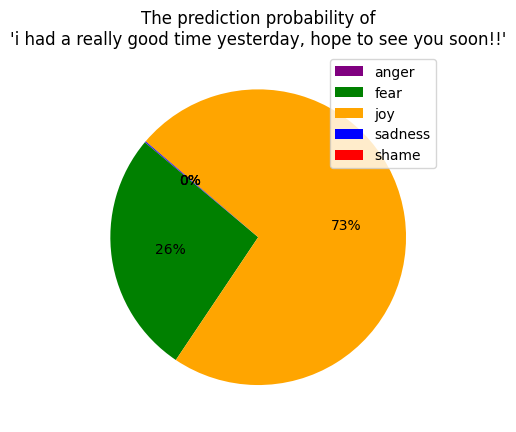

In [8]:
import matplotlib.pyplot as plt

labels = ["anger","fear",  "joy", "sadness", "shame"]
colors = ['purple', 'green', 'orange', 'blue', 'red']

# Creating Pie Charts
plt.pie(prediction[0],  autopct='%d%%', startangle=140,colors=colors)



title_text = f"The prediction probability of\n'{a}'"
plt.title(title_text)

plt.legend(labels, loc='best')

plt.show()